##  Homework 2 - Problem 5 : Handwritten digits

### Student: Dimitrios Tanoglidis

In [2]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    #plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

### Import the MNIST dataset

I downloaded the MNIST data set, which is actually consisted  out of a training set ($\sim 60000$ images) and a test set ($\sim 10000$ images). 

After reading the data, I will combine them into one set and split them into $60\%$ training, $20 \%$ development and $20 \%$ test sets.

In [3]:
data_train = np.float64(np.load("/Users/Dimitris/Desktop/Machine_Learning/HW2/train_images.npy"))
data_test = np.float64(np.load("/Users/Dimitris/Desktop/Machine_Learning/HW2/test_images.npy"))
labels_train = np.float32(np.load("/Users/Dimitris/Desktop/Machine_Learning/HW2/train_labels.npy"))
labels_test = np.float32(np.load("/Users/Dimitris/Desktop/Machine_Learning/HW2/test_labels.npy"))


# Combine all them into one dataset - divide the data by 255 to normalize the values
data = np.concatenate((data_train, data_test))/255.
labels = np.concatenate((labels_train, labels_test))

# Print their shapes to see
print(np.shape(data));print(np.shape(labels))
# Print also min and max values
print(np.min(data),np.max(data))

(70000, 784)
(70000, 1)
(0.0, 1.0)


And let's plot a subset (say the first twenty) of them...

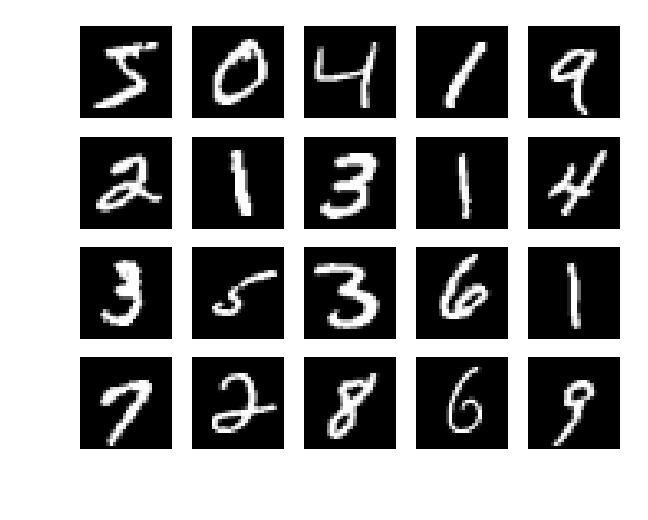

In [4]:
subset = data[0:20,:]
nrows = 4
ncols = 5

plt.figure(figsize=(ncols*0.7, nrows*0.7))

for i in xrange(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(subset[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
    
plt.axis('off')
plt.show()

Now split the data into $60 \%$ training, $20 \%$ development and $20 \%$ test sets.

First split into $60 \%$-$40\%$ and then take the $40 \%$ and split it into two!

In [6]:
from sklearn.model_selection import train_test_split

# Split into 60% train set and 40% "rest" set - we will use it to further sub-split
data_train, data_rest, labels_train, labels_rest = train_test_split(data, labels, train_size = 0.60, random_state=42)

# Further split the rest set into development and test sets
data_devel, data_test, labels_devel, labels_test = train_test_split(data_rest, labels_rest, train_size = 0.50, random_state=42)

# Print their sizes:
print(np.shape(data_train),np.shape(data_devel), np.shape(data_test))

((42000, 784), (14000, 784), (14000, 784))


## Part 1: PCA

In this part I will perform the Principal Components Analysis (PCA) on the training data.


#### (a) Extract principal components

Here I will follow the more intuitive approach of eigendecomposition of the covariance matrix of our features.

In [7]:
# Subtract the means
data_train_new = np.zeros((42000,784))
data_means = np.zeros(784)
for i in range(784):
    data_means[i] = np.sum(data_train[:,i])/42000.0
    data_train_new[:,i] = data_train[:,i] - data_means[i]

# ===================================================
# Get the covariance matrix
cov_mat = np.cov(data_train_new.T)

# Get eigenvectors - eigenvalues
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Keep real part - imaginary part is zero as it should, but for some reason the output 
# gives a +0j imaginary part which is annoying
eig_vals = np.real(eig_vals)
eig_vecs = np.real(eig_vecs)

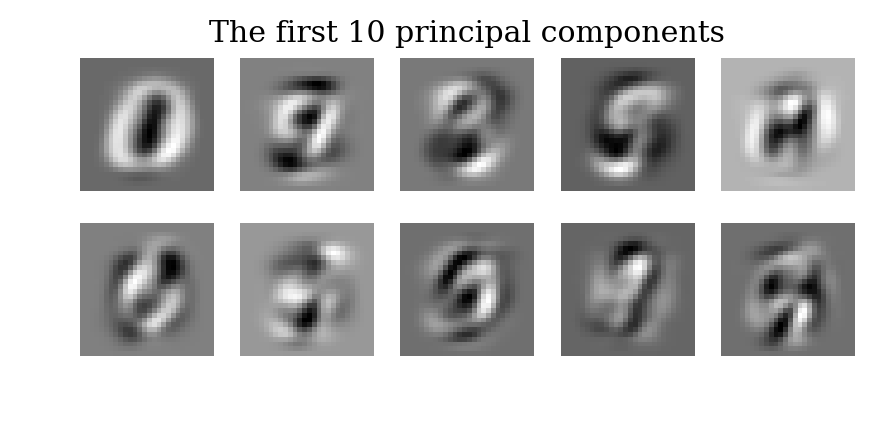

In [8]:
# Eigenvectors are the columnts of the matrix
eig_vecs_sub = (eig_vecs.T)[0:10]

nrows = 2
ncols = 5

plt.figure(figsize=(ncols, nrows))



for i in xrange(nrows*ncols):
    if (i==3):
        plt.title("The first 10 principal components")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(eig_vecs_sub[i].reshape((28,28)), cmap='gray')
    plt.axis('off')


plt.axis('off')
plt.show()

#### (b) Plot variance

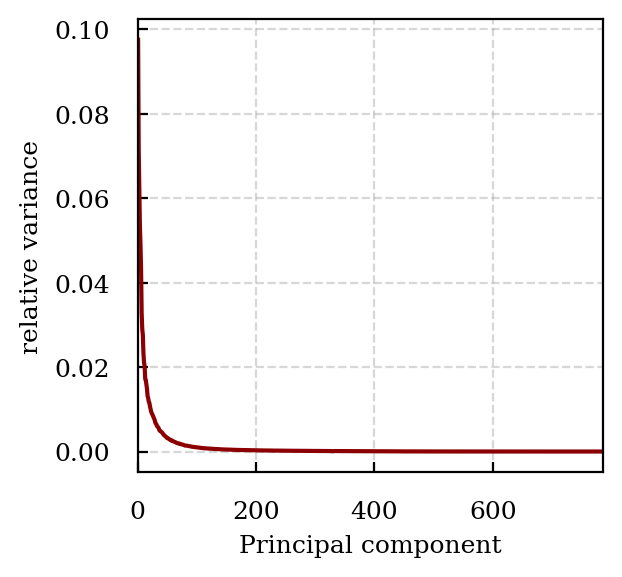

In [9]:
prin_comp = np.arange(1,785)

plt.figure(figsize=(3, 3))

plt.plot(prin_comp, eig_vals/np.sum(eig_vals), c = 'darkred')
plt.xlim(0,785)
plt.grid(ls='--',alpha=0.5)

plt.xlabel('Principal component');plt.ylabel('relative variance')
plt.show()

Let's also plot the variance up to the $\sim 100$th principal component


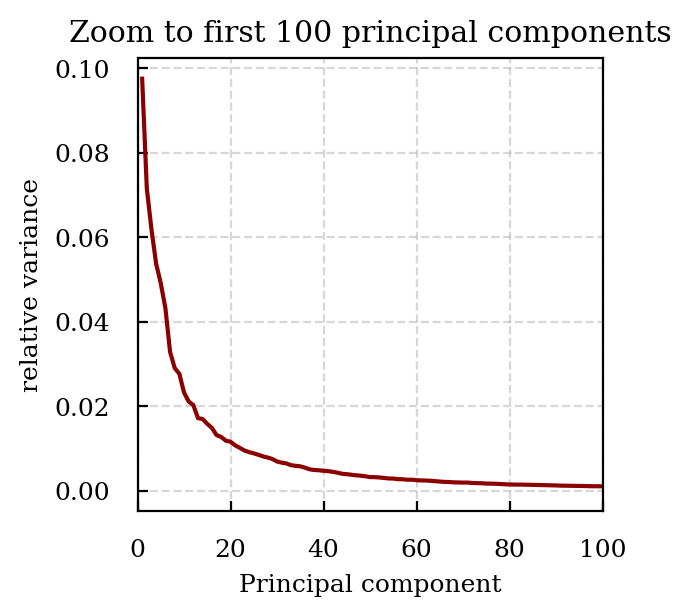

In [12]:
plt.figure(figsize=(3, 3))

plt.plot(prin_comp, eig_vals/np.sum(eig_vals), c = 'darkred')
plt.xlim(0,100)
plt.grid(ls='--',alpha=0.5)
plt.xlabel('Principal component');plt.ylabel('relative variance')
plt.title('Zoom to first 100 principal components')
plt.show()

#### (c) Dimension reduction

Let the $(784 \times 784)$ matrix of principal components be the matrix $U$:

Let also $\hat{U}$ the matrix created by keeping just the first $m$ principal components (eigenvectors). That matrix has, obviously, dimensions $(784 \times m)$. 

To get the projection, $Y_i$ of a data point $\tilde{X_i}$ (where $\tilde{X}_i = X_i - \bar{X}), we perform:

\begin{equation}
Y_i = \hat{U}^T\tilde{X_i}
\end{equation}
  
$Y_i$ is a vector $(m \times 1)$, so the dimension has been reduced.

Then we can transform this back into a $784$-length vector by (also adding again the mean):

\begin{equation}
X_i^{approx} = \hat{U}Y_i + \bar{X} = \hat{U}\hat{U}^T\tilde{X_i} = P\tilde{X_i}+ \bar{X}
\end{equation}

Where we defined the projection-deprojection matrix as $P = \hat{U}\hat{U}^T$.

We will preform this for $m = [5,10,20,50,100,200]$ for a number of data points.

In [21]:
# First get the transpose of eig_vecs  
eigen_vec_mat = eig_vecs.T 

# Create the matrices with columns the first m principal components
U_5 = (eigen_vec_mat[0:5]).T
U_10 = (eigen_vec_mat[0:10]).T
U_20 = (eigen_vec_mat[0:20]).T
U_50 = (eigen_vec_mat[0:50]).T
U_100 = (eigen_vec_mat[0:100]).T
U_200 = (eigen_vec_mat[0:100]).T

# Create the projection matrices:
P_5 = np.matmul(U_5, U_5.T)
P_10 = np.matmul(U_10, U_10.T)
P_20 = np.matmul(U_20, U_20.T)
P_50 = np.matmul(U_50, U_50.T)
P_100 = np.matmul(U_100, U_100.T)
P_200 = np.matmul(U_100, U_200.T)

- For the first data point.

In [35]:
X_first = data_train_new[0]

# Create the projection/deprojections
X_pdj_5 = np.matmul(P_5,X_first) + data_means
X_pdj_10 = np.matmul(P_10,X_first) + data_means
X_pdj_20 = np.matmul(P_20,X_first) + data_means
X_pdj_50 = np.matmul(P_50,X_first) + data_means
X_pdj_100 = np.matmul(P_100,X_first) + data_means
X_pdj_200 = np.matmul(P_200,X_first) + data_means

X_projections = [X_pdj_5,X_pdj_10,X_pdj_20,X_pdj_50,X_pdj_100,X_pdj_200]

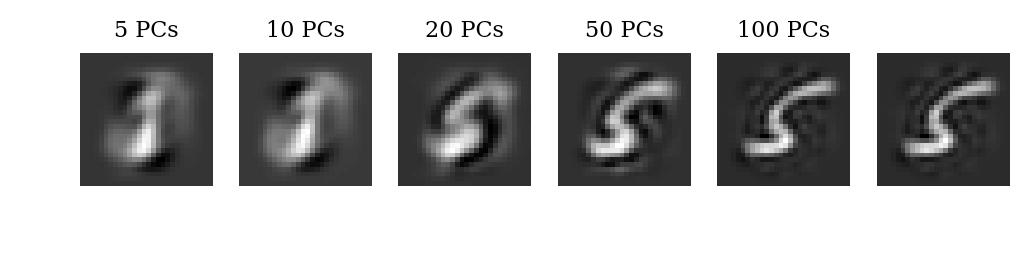

In [36]:
nrows = 1
ncols = 6
j = [5,10,20,50,100,200]

plt.figure(figsize=(ncols, nrows))
for i in xrange(nrows*ncols):
    plt.title("{0} PCs".format(j[i-1]), fontsize=8)
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_projections[i].reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.axis('off')
plt.show()

- 10th data point

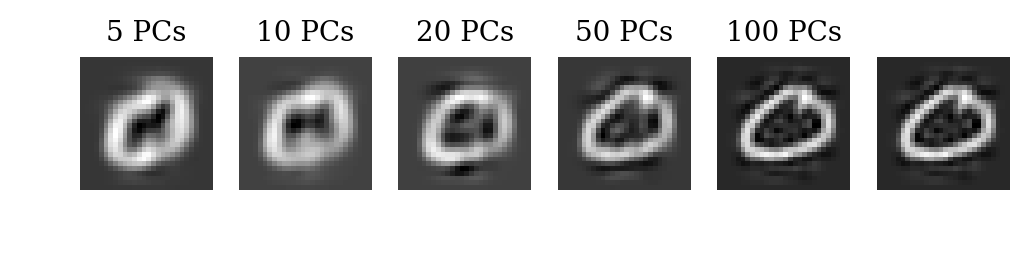

In [37]:
X_tenth = data_train_new[10]

# Create the projection/deprojections
X_pdj_5 = np.matmul(P_5,X_tenth) + data_means
X_pdj_10 = np.matmul(P_10,X_tenth) + data_means
X_pdj_20 = np.matmul(P_20,X_tenth) + data_means
X_pdj_50 = np.matmul(P_50,X_tenth) + data_means
X_pdj_100 = np.matmul(P_100,X_tenth) + data_means
X_pdj_200 = np.matmul(P_200,X_tenth) + data_means

X_projections = [X_pdj_5,X_pdj_10,X_pdj_20,X_pdj_50,X_pdj_100,X_pdj_200]


plt.figure(figsize=(ncols, nrows))
for i in xrange(nrows*ncols):
    plt.title("{0} PCs".format(j[i-1]), fontsize=10)
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_projections[i].reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.axis('off')
plt.show()

- 20th data point

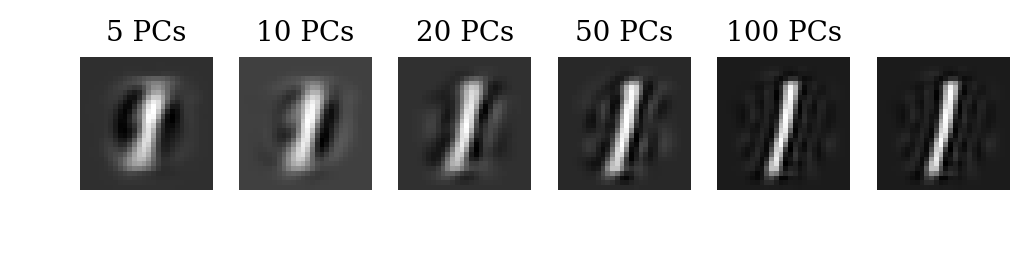

In [38]:
X_20th = data_train_new[20]
# Create the projection/deprojections
X_pdj_5 = np.matmul(P_5,X_20th) + data_means
X_pdj_10 = np.matmul(P_10,X_20th) + data_means
X_pdj_20 = np.matmul(P_20,X_20th) + data_means
X_pdj_50 = np.matmul(P_50,X_20th) + data_means
X_pdj_100 = np.matmul(P_100,X_20th) + data_means
X_pdj_200 = np.matmul(P_200,X_20th) + data_means
X_projections = [X_pdj_5,X_pdj_10,X_pdj_20,X_pdj_50,X_pdj_100,X_pdj_200]

plt.figure(figsize=(ncols, nrows))
for i in xrange(nrows*ncols):
    plt.title("{0} PCs".format(j[i-1]), fontsize=10)
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_projections[i].reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.axis('off')
plt.show()